<div style="text-align: center;">
    <h1>Sirene vs RNE</h1>
</div>

Nous avons extrait sensiblement les mêmes informations de bases de données gouvernementales dans ces notebooks :

- [Sirene](../Notebooks/2.%20Sirene.ipynb)
- [RNE](../Notebooks/1.%20Registre%20national%20des%20entreprises.ipynb)

Nous allons ici les comparer l'une et l'autre et voir quel dataset final utiliser. 

Le dataset final sera une liste la plus exhaustive possible des établissements (au sens du SIRET) en activité en France et de leur localisation (à la maille de la commune).

In [1]:
! pip install -q missingno matplotlib-venn

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# 1. Comparaison des données

In [3]:
path_rne = "../data/Données nationales/RNE.parquet"

df_rne = pd.read_parquet(path_rne)

df_rne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074487 entries, 0 to 5074486
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   codeApe               object
 1   siret                 int64 
 2   nomCommercial         object
 3   codeInseeCommune      object
 4   adresse               object
 5   diffusionCommerciale  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 198.4+ MB


In [4]:
path_sirene = "../data/Données nationales/Sirene.parquet"

df_sirene = pd.read_parquet(path_sirene)

df_sirene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15438154 entries, 0 to 15438153
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   siret                 int64 
 1   diffusionCommerciale  bool  
 2   codeInseeCommune      object
 3   codeApe               object
 4   adresse               object
 5   nomCommercial         object
dtypes: bool(1), int64(1), object(4)
memory usage: 603.6+ MB


Quelles sont les valeurs manquantes ?

<Axes: >

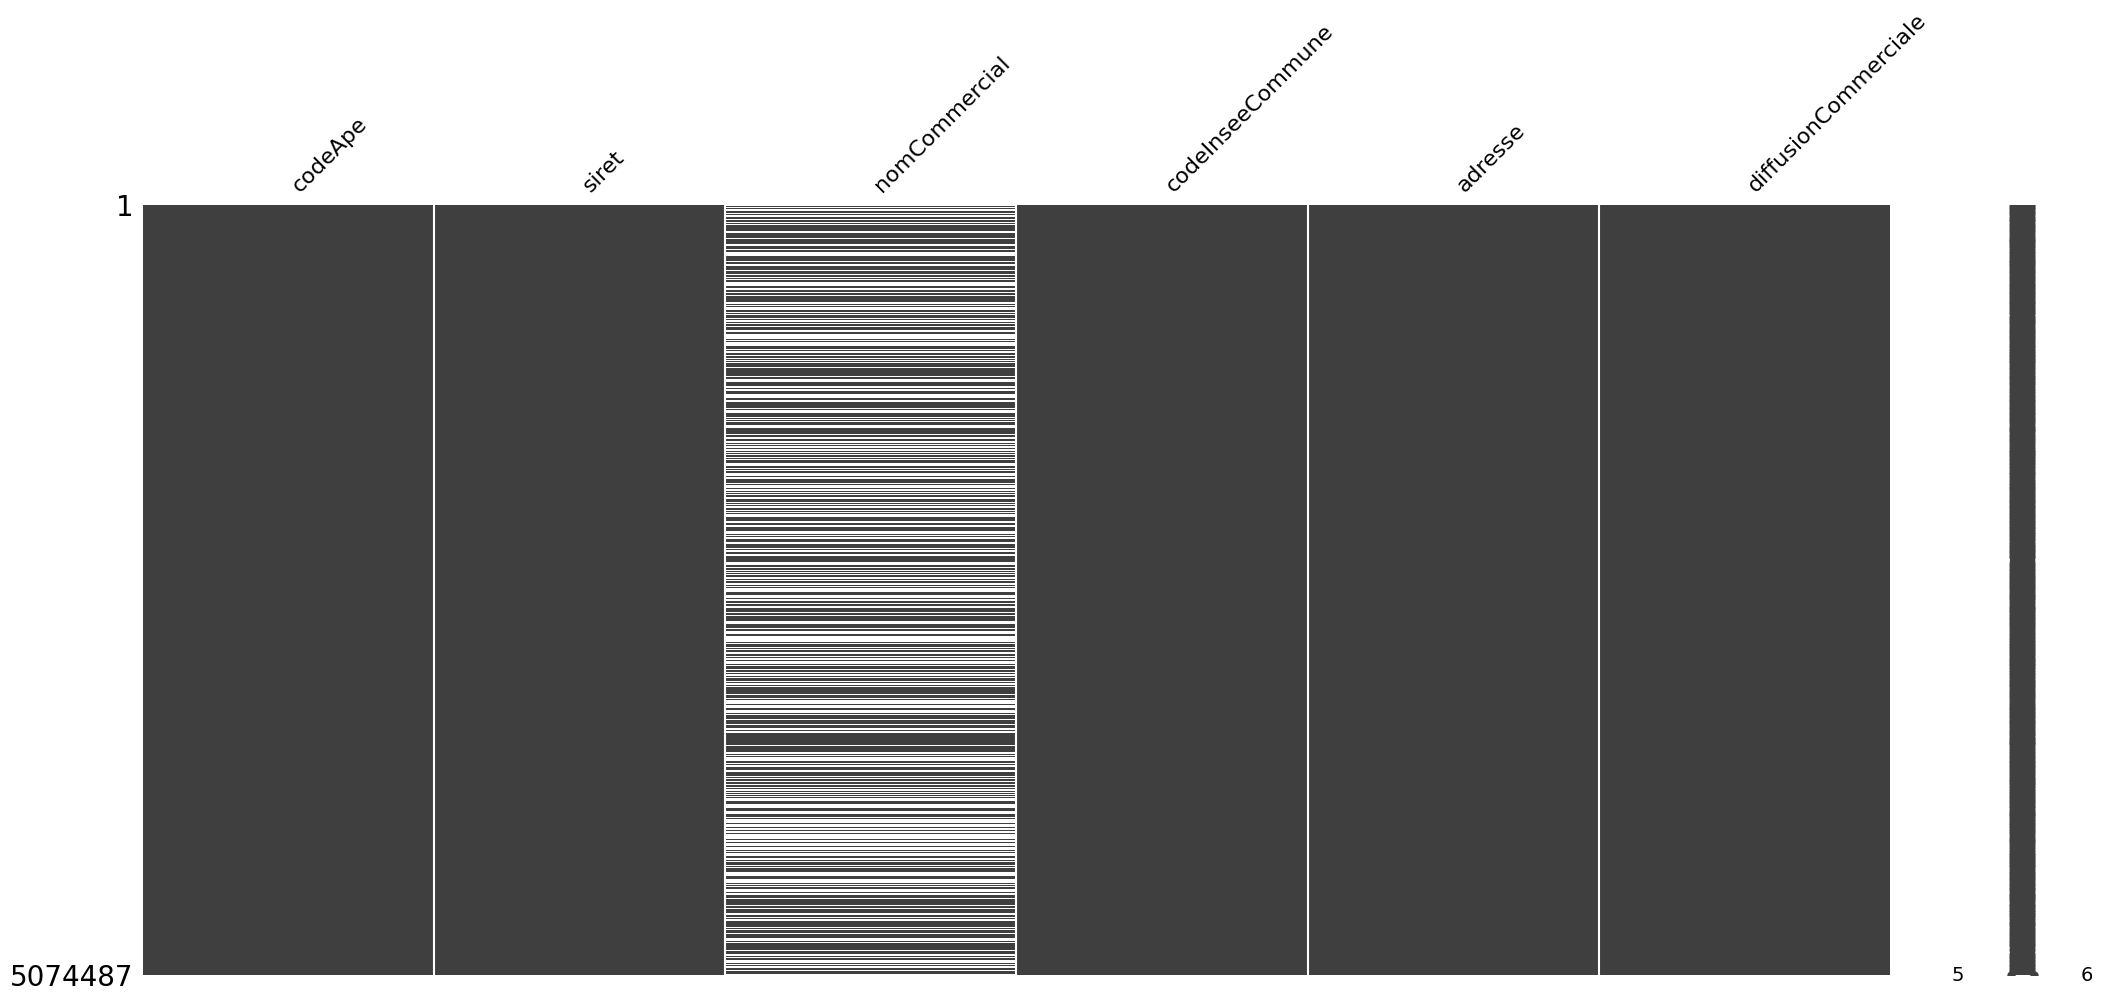

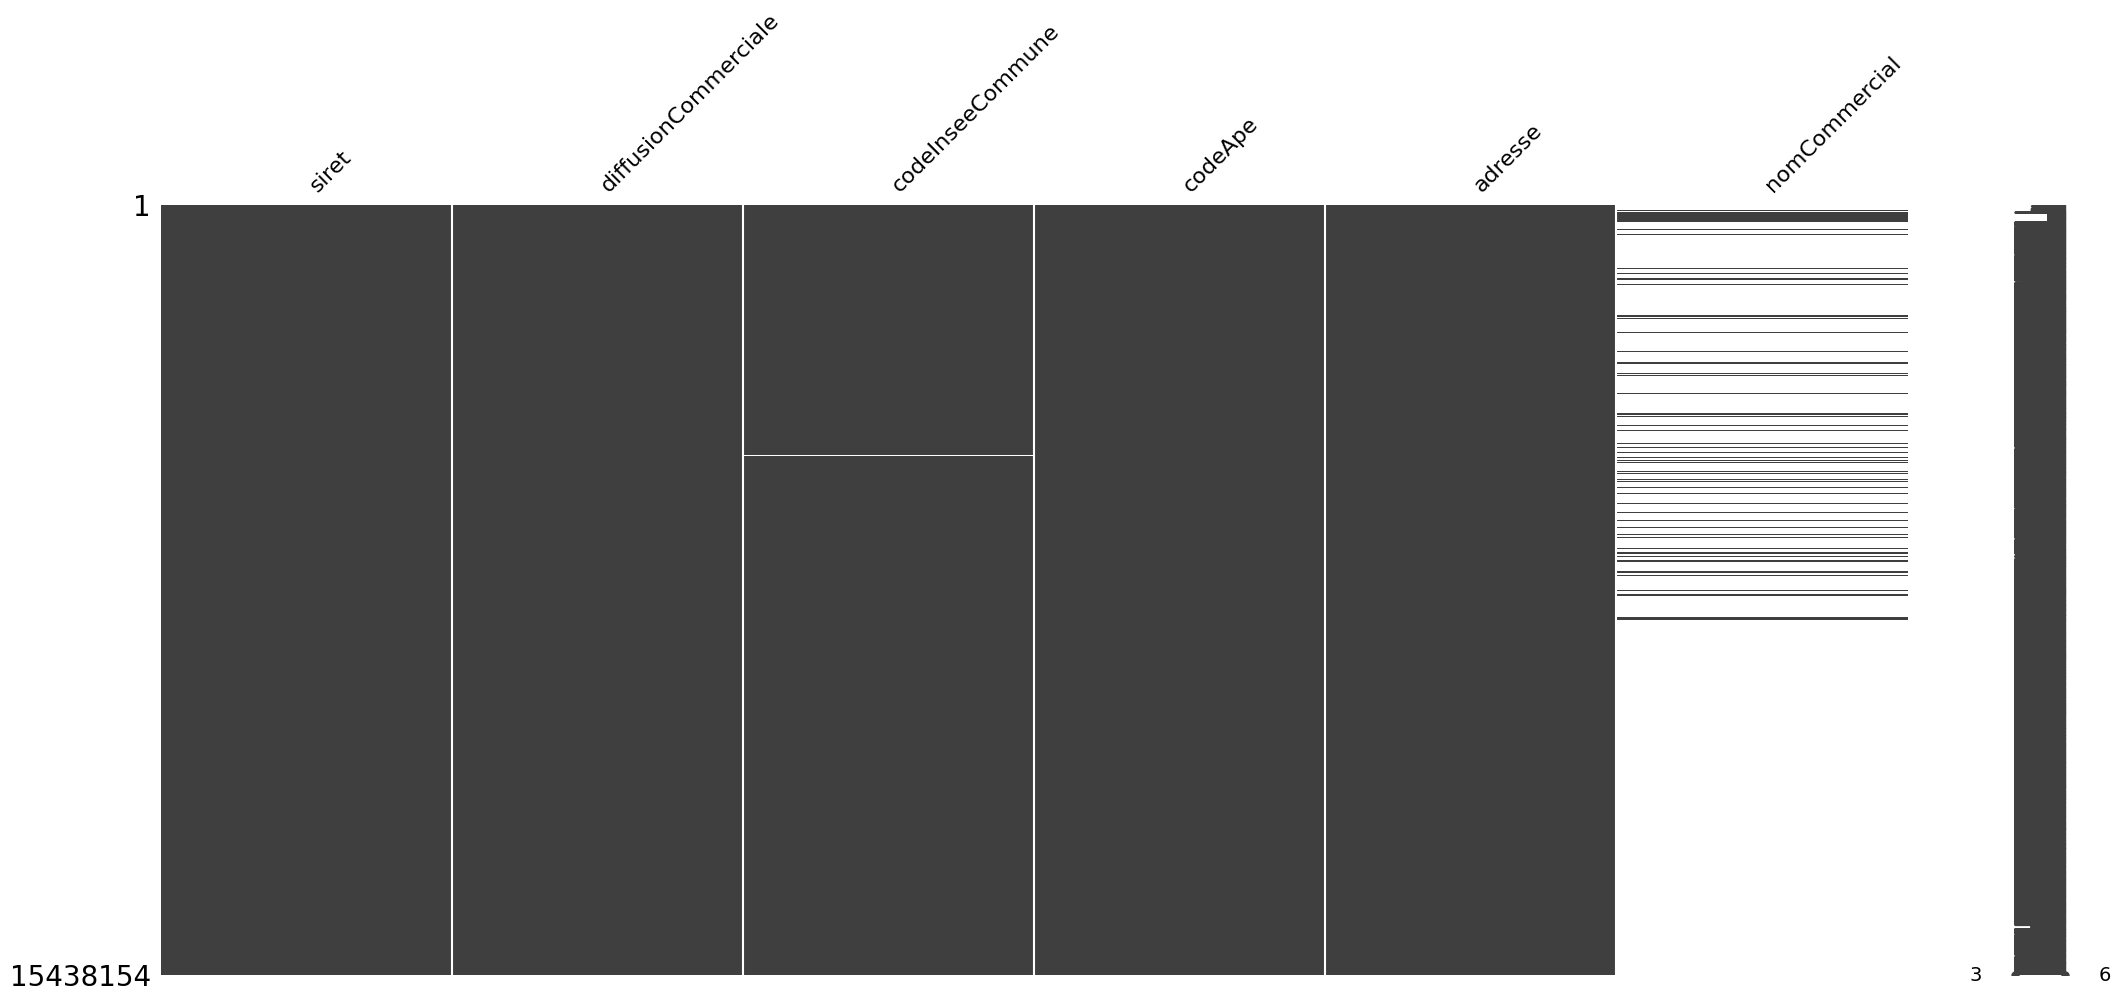

In [5]:
df_rne.replace("", np.nan, inplace=True)
msno.matrix(df_rne)

# On regarde la distribution des valeurs manquantes
df_sirene.replace("", np.nan, inplace=True)
df_sirene.replace("nan", np.nan, inplace=True)
msno.matrix(df_sirene)

# 2. Gestion des établissements redondants

Après nouvelle exploitation du RNE, cette partie n'est plus nécessaire.

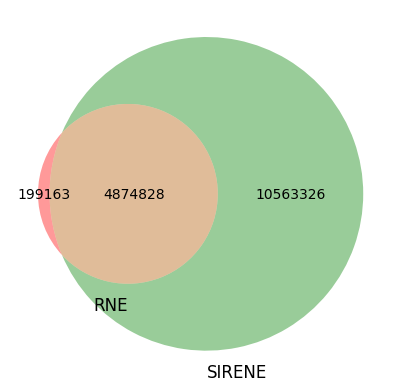

In [6]:
set_1 = set(df_rne.siret)
set_2 = set(df_sirene.siret)

venn2([set_1, set_2], ("RNE", "SIRENE"))

plt.show()

In [7]:
siret_redondants = list(set_1.intersection(set_2))

df_intersect = pd.merge(
    df_rne[df_rne["siret"].isin(siret_redondants)],
    df_sirene[df_sirene["siret"].isin(siret_redondants)],
    on="siret",
    how="inner",
    suffixes=["_rne", "_sirene"],
)

Est ce que les données catégoriques sont comparables ?

In [8]:
cat_col = ["codeInseeCommune", "codeApe", "diffusionCommerciale"]

for i in cat_col:
    df_intersect[i + "_equal"] = df_intersect[i + "_rne"] == df_intersect[i + "_sirene"]
    print(
        "Concordance {} : {:.2%} ".format(
            i, df_intersect[i + "_equal"].sum() / df_intersect.shape[0]
        )
    )

Concordance codeInseeCommune : 99.99% 
Concordance codeApe : 88.11% 
Concordance diffusionCommerciale : 92.08% 


Visiblement oui, dans la majeure partie des cas.

Par souci de simplicité, on va arbitrairement choisir la base sirene comme juge.

In [9]:
columns_to_drop = [i + "_rne" for i in cat_col] + [i + "_equal" for i in cat_col]
df_intersect = df_intersect.drop(columns_to_drop, axis=1)

Comparaison simple pour les données textuelles : on prend la source la plus complète

In [10]:
text_col = ["adresse", "nomCommercial"]

for i in text_col:
    print(i)

    df_intersect[i] = df_intersect.apply(
        lambda row: row[i + "_rne"]
        if len(str(row[i + "_rne"])) > len(str(row[i + "_sirene"]))
        else row[i + "_sirene"],
        axis=1,
    )

adresse
nomCommercial


In [11]:
df_intersect = df_intersect.drop(
    ["nomCommercial_rne", "adresse_rne", "adresse_sirene", "nomCommercial_sirene"],
    axis=1,
)

df_intersect.columns = [
    "siret",
    "diffusionCommerciale",
    "codeInseeCommune",
    "codeApe",
    "adresse",
    "nomCommercial",
]

# 3. Création de la base finale

In [12]:
siret_rne_to_add = set_1.difference(set_2)
siret_sirene_to_add = set_2.difference(set_1)

df_rne_to_add = df_rne[df_rne.siret.isin(siret_rne_to_add)]
df_sirene_to_add = df_sirene[df_sirene.siret.isin(siret_sirene_to_add)]

df_final = pd.concat([df_rne_to_add, df_intersect, df_sirene_to_add], axis=0)

# 4. Sauvegarde du fichier

In [13]:
df_final = pd.concat([df_rne, df_sirene], axis=0)

In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20512641 entries, 0 to 15438153
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   codeApe               object
 1   siret                 int64 
 2   nomCommercial         object
 3   codeInseeCommune      object
 4   adresse               object
 5   diffusionCommerciale  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 958.6+ MB


In [15]:
dtypes = {
    "codeApe": "object",
    "siret": np.int64,
    "nomCommercial": "object",
    "codeInseeCommune": "object",
    "adresse": "object",
    "diffusionCommerciale": "bool",
}

df_final.astype(dtypes, copy=False, errors="ignore")
df_final.to_parquet("../data/Données nationales/RNE_Sirene.parquet", index=False)